In [1]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


# Voy a fitear el modelo en funcion del suavizado

In [2]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv):
    b1, b2, b4 = params
    model = F0 + b1 * F1 + b2 * F2 + b4*F4 - 1
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b4 = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -50 < b4 < 50:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F4, C_inv)

def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [3]:
def cadena_fit(smooth, rmin, nsteps = 10000, path = '/home/arodriguez/BACCO/bias-voids/IATE/perfiles/'):

    damping_scale = 0.75
    
    f0_file = np.load(path+'perfiles_F0_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
    f1_file = np.load(path+'perfiles_F1_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
    f2_file = np.load(path+'perfiles_F2_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
    f4_file = np.load(path+'perfiles_F4_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
    
    f0 = f0_file[:,1:]
    f1 = f1_file[:,1:]
    f2 = f2_file[:,1:]
    f4 = f4_file[:,1:]
    
    realizaciones = 80
    
    mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
    mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
    mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
    mean_4, error_4 = pg.perfil_jack(f4,realizaciones)
    
    original = np.load(path+'perfiles_simulation_smooth_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
    obs = original[:,1:]
    
    mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)
    
    C = covariance_mat(mean_obs,all_obs)
    
    num_bines = mean_obs.shape[0]
    njack = realizaciones
    factor_h = 1 - (num_bines+1)/(njack-1)
    
    F_obs = mean_obs
    F0 = mean_0
    F1 = mean_1
    F2 = mean_2
    F4 = mean_4


    C_inv = factor_h*np.linalg.inv(C)


    # Configuración de MCMC
    ndim = 3  # Número de parámetros
    nwalkers = 50  # Número de walkers
      # Número de pasos
    
    # Inicializar walkers aleatoriamente
    starting_guesses = np.random.rand(nwalkers, ndim)
    
    # Ejecutar MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2, F4, C_inv))
    _ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)
    
    # Análisis de resultados
    samples = sampler.get_chain(discard=500, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
    b1_samples, b2_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2]
    
    return b1_samples, b2_samples, b4_samples

In [6]:
b1_samples, b2_samples, b4_samples = cadena_fit(15,16, nsteps = 1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 265.46it/s]


In [7]:
dist = np.linspace(0,3,30)

b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

BACCO: 1.2810367617112577 0.8994542290372903 -4.062777709136896


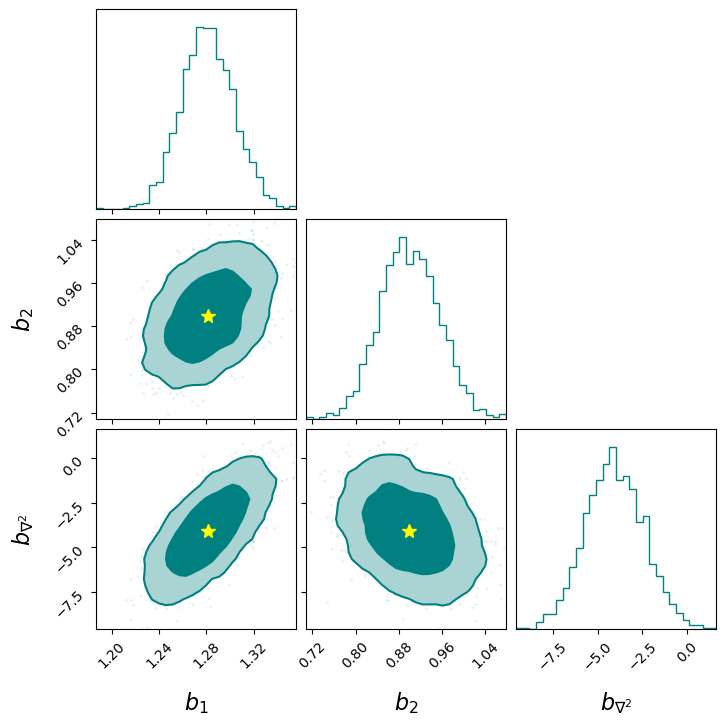

In [8]:
import corner
import random


#seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples, b2_samples, b4_samples]).T,
                       labels=["$ b_1 $", "$b_2$", "$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[3].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[6].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
axes[7].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

print('BACCO:',b1_mean, b2_mean, b4_mean)

In [9]:
suavizados = [0,3,6,9,12,15]
b1 = []
b2 = []
b4 = []
b1_e = []
b2_e = []
b4_e = []


for R in suavizados:
    b1_samples, b2_samples, b4_samples = cadena_fit(R,16, nsteps = 1000)
    
    b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
    b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
    b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
    
    b1.append(b1_mean)
    b2.append(b2_mean)
    b4.append(b4_mean)
    
    b1_e.append(b1_std)
    b2_e.append(b2_std)
    b4_e.append(b4_std)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 263.87it/s]


Text(0, 0.5, '$value$')

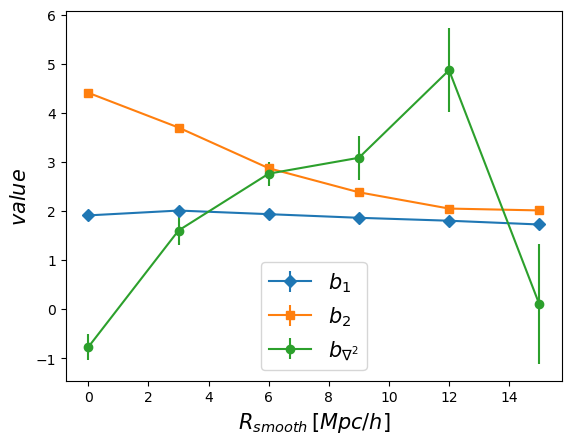

In [32]:
plt.errorbar(suavizados,b1,b1_e,label='$b_1$',marker='D')
plt.errorbar(suavizados,b2,b2_e,label='$b_2$',marker='s')
plt.errorbar(suavizados,b4,b4_e,label='$b_{\\nabla^2}$',marker='o')
plt.legend(fontsize=15)
plt.xlabel('$R_{smooth}\,[Mpc/h]$',size=15)
plt.ylabel('$value$',size=15)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:36<00:00, 272.10it/s]


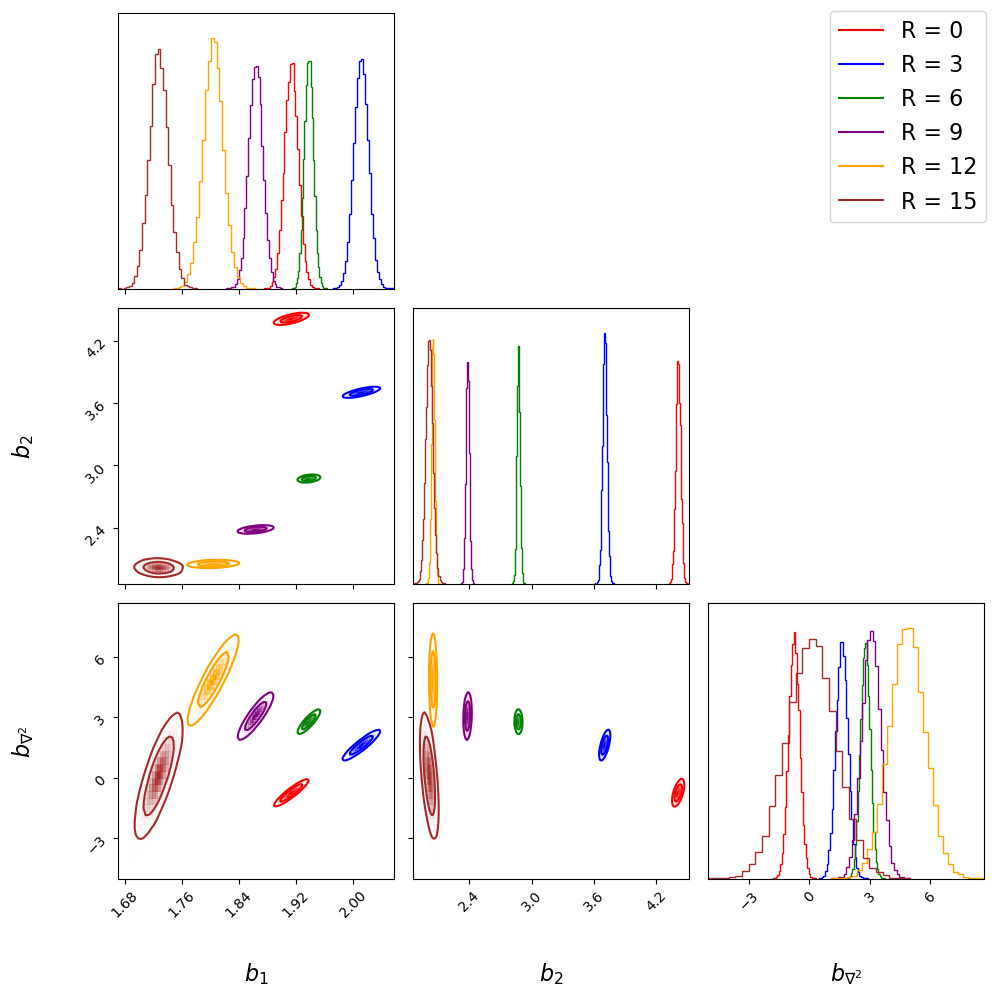

In [37]:
suavizados = [0,3,6,9,12,15]
nsteps = 10000

b1 = []
b2 = []
b4 = []
b1_e = []
b2_e = []
b4_e = []



# Crear la figura y los ejes antes del bucle
fig, axarr = plt.subplots(3, 3, figsize=(10, 10))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']  # Colores para cada suavizado

# Diccionario para almacenar los handles de las leyendas
handles = []

for i, R in enumerate(suavizados):
    # Obtener las muestras de la cadena de Markov
    b1_samples, b2_samples, b4_samples = cadena_fit(R, 15, nsteps = nsteps)
    
    # Calcular la media y la desviación estándar de las muestras
    b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
    b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
    b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)
    
    # Agregar los resultados a las listas
    b1.append(b1_mean)
    b2.append(b2_mean)
    b4.append(b4_mean)
    
    b1_e.append(b1_std)
    b2_e.append(b2_std)
    b4_e.append(b4_std)
    
    # Generar el gráfico de contornos con un color específico
    corner_plot = corner.corner(np.vstack([b1_samples, b2_samples, b4_samples]).T,
                                labels=["$b_1$", "$b_2$", "$b_{\\nabla^2}$"],
                                bins=30, smooth=1.0, plot_datapoints=False,
                                plot_contours=True, fill_contours=False,
                                levels=[0.68, 0.95],
                                label_kwargs={"fontsize": 16},
                                color=colors[i],
                                fig=fig)
    
    # Crear un handle para la leyenda
    handles.append(plt.Line2D([], [], color=colors[i], label=f'R = {R}'))

# Agregar la leyenda al gráfico
fig.legend(handles=handles, loc='upper right', fontsize=16)

# Ajustar los espacios entre subplots
plt.tight_layout()

Text(0, 0.5, '$value$')

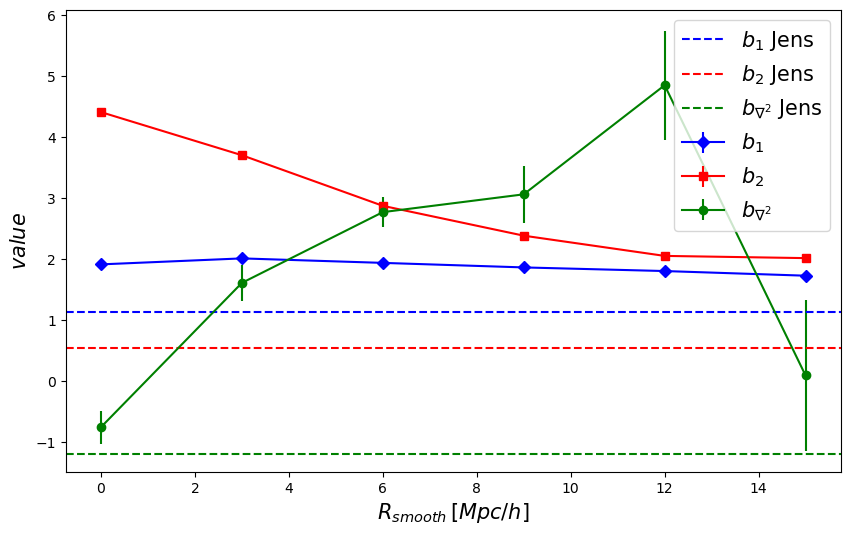

In [41]:
# Crear una nueva figura para las barras de error
plt.figure(figsize=(10, 6))
plt.errorbar(suavizados, b1, yerr=b1_e, label='$b_1$', marker='D', color='blue')
plt.errorbar(suavizados, b2, yerr=b2_e, label='$b_2$', marker='s',color='red')
plt.errorbar(suavizados, b4, yerr=b4_e, label='$b_{\\nabla^2}$', marker='o',color='green')

# Agregar líneas punteadas para los valores de Jens
b1_jens = 1.13
b2_jens = 0.55
b4_jens = -1.19
plt.axhline(y=b1_jens, color='b', linestyle='--', label='$b_1$ Jens')
plt.axhline(y=b2_jens, color='r', linestyle='--', label='$b_2$ Jens')
plt.axhline(y=b4_jens, color='g', linestyle='--', label='$b_{\\nabla^2}$ Jens')

# Configurar el gráfico de barras de error
plt.legend(fontsize=15)
plt.xlabel('$R_{smooth}\,[Mpc/h]$', size=15)
plt.ylabel('$value$', size=15)